In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS, HMC
import torch as T
import random

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

pyro.enable_validation()

## Inferring the bias of a coin 
See the effects of varying the number of observations.

In [2]:
def generate_obs(p, n):
    return T.bernoulli(p * T.ones(n))
    # return T.from_numpy(np.random.binomial(1, p, size=n)).to(T.float32)
    # return T.tensor([random.uniform(0,1) <= p for _ in range(n)]).to(T.float32)

def model(obs_data):
    """Compute Pr(bias|obs)"""
    α, β = 1, 1
    bias = pyro.sample('bias', dist.Beta(α, β))
    
    with pyro.plate('data', len(obs_data)) as idx:
        out = pyro.sample('obs', dist.Bernoulli(bias), obs=obs_data)
    
def infer(obs):
    pyro.clear_param_store()

    kernel = NUTS(
        model, jit_compile=True, ignore_jit_warnings=True
    )
    posterior = MCMC(
        kernel, num_samples=10_000, warmup_steps=1_000
    )
    posterior.run(obs)
    
    return posterior.get_samples()['bias']

p = 0.35
bias = {
    n: infer(generate_obs(p, n))
    for n in [10, 100, 1000]
}

Sample: 100%|█████████████████████████████████████| 11000/11000 [00:33, 328.55it/s, step size=9.53e-01, acc. prob=0.906]                                                                                                                      


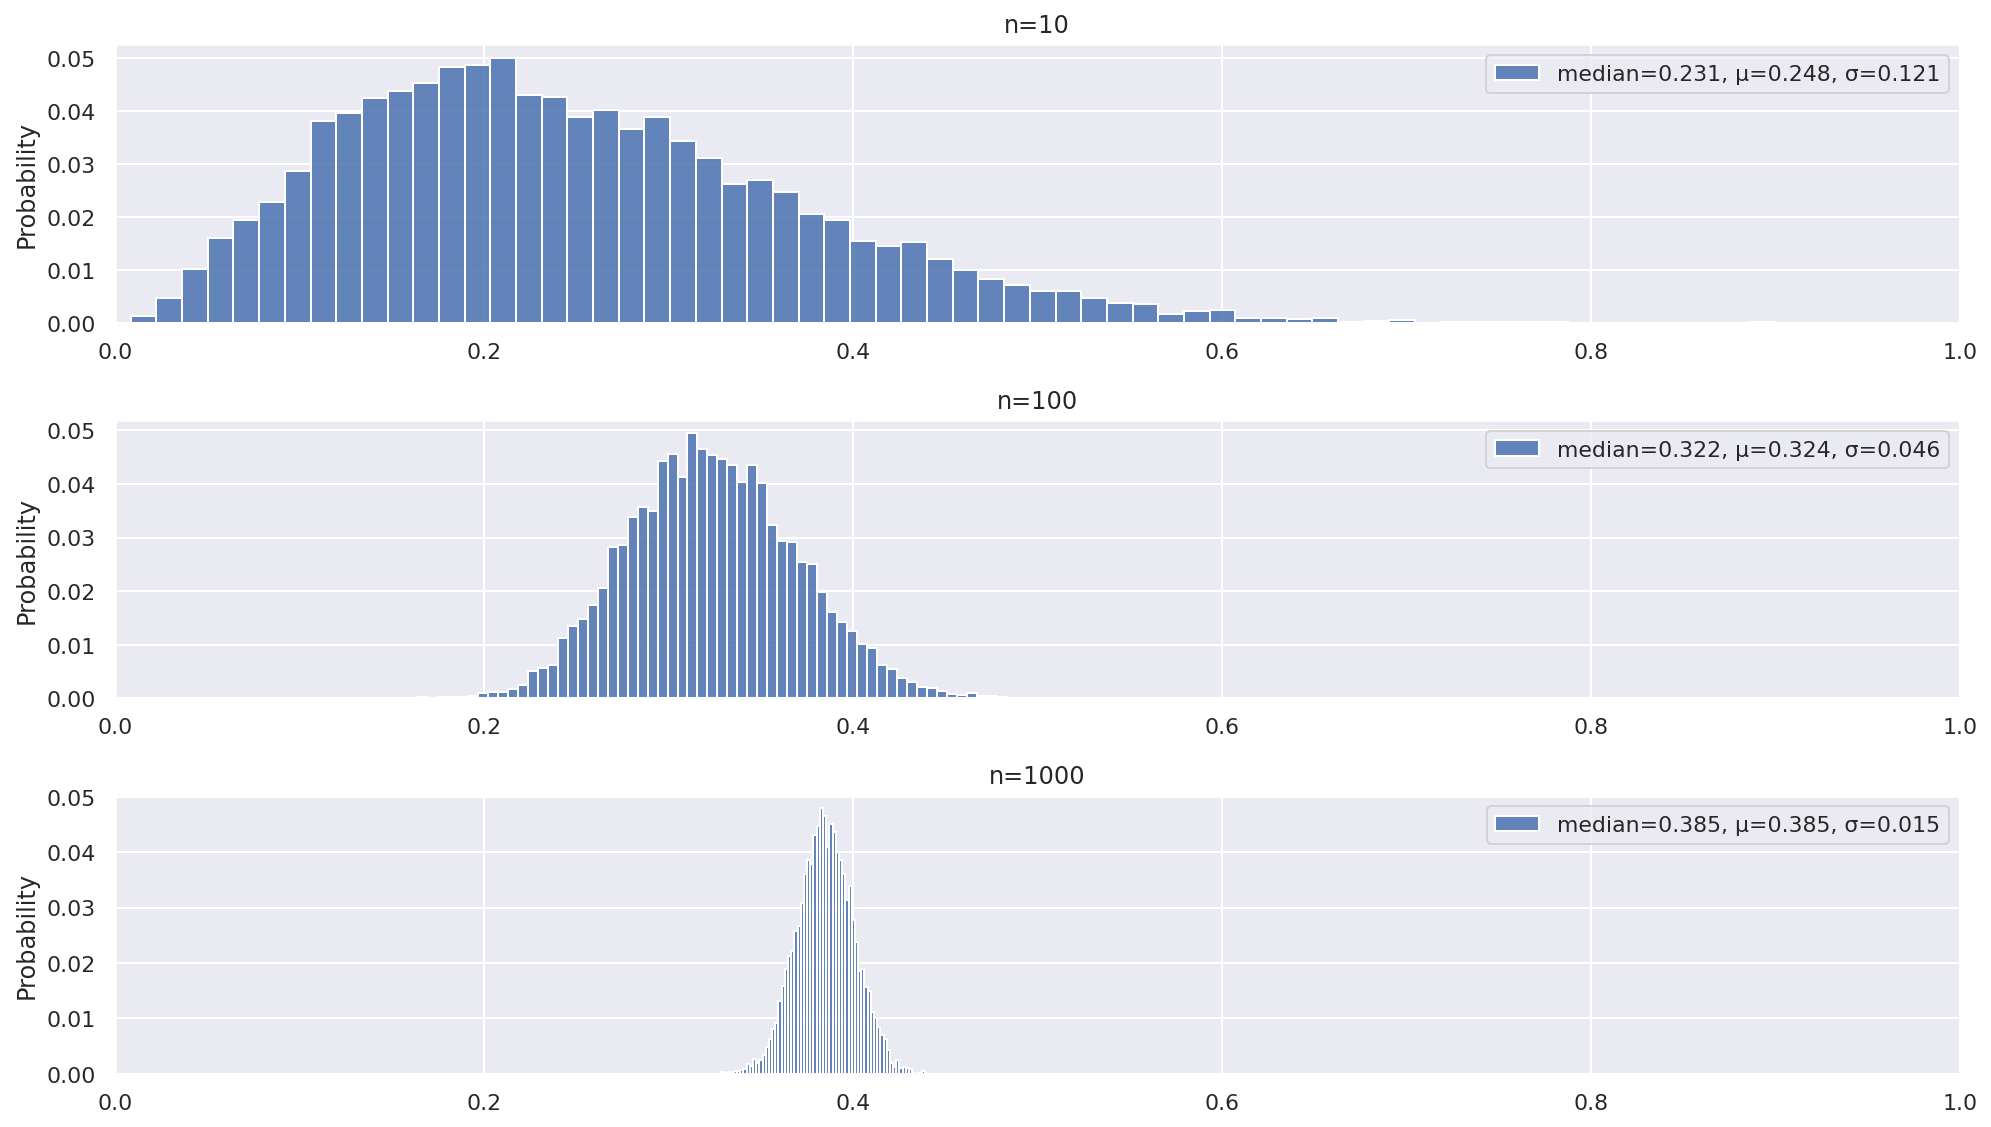

In [3]:
plt.figure(figsize=(14, 8))

for i, (n, samples) in enumerate(bias.items(), start=1):
    plt.subplot(len(bias), 1, i)
    sns.histplot(samples, alpha=0.85, bins=64, color='b', stat='probability', label=f"median={np.median(samples):.3f}, μ={samples.mean():.3f}, σ={samples.std():.3f}")
    plt.legend()
    plt.title(f"{n=}", fontsize=12)
    plt.xlim([0, 1])
    # plt.xticks(np.linspace(0.7,1,21))
    
plt.tight_layout()